In [1]:
import pandas as pd
import numpy as np
import lib_tools as pt # Project Tools

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from datetime import date, datetime

start_year = 2005      # Année de début de période d'étude
end_year   = 2021      # Année de fin de période d'étude   
chk        = False     # Affichage de log des checks
sampled    = True     # Travail sur données samplées de df_all

df_all = pt.get_work_df(start_year, end_year, sampled, chk)

### Transformation des  -1 (non renseigné) en *Null*

In [2]:
df_all = pt.manage_not_specified(df_all)

### Représentation graphique des *Null*

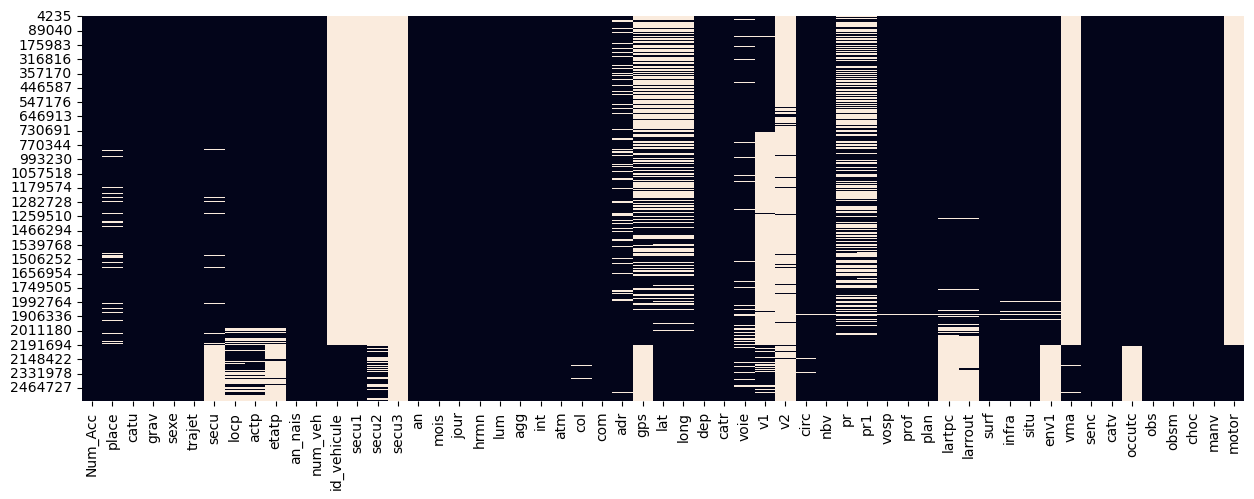

In [3]:
df_sample = df_all.sample(10000)
df_sample = df_sample.sort_values(by=['an', 'mois', 'jour'], ascending=True)

plt.figure(figsize=(15,5))
ax = sns.heatmap(df_sample.isna(), cbar=False);

### Suppression de variables avec plus de 8 % de *Null*

In [4]:
df_all = pt.rmv_col_too_much_null(df_all, 0.08, False)

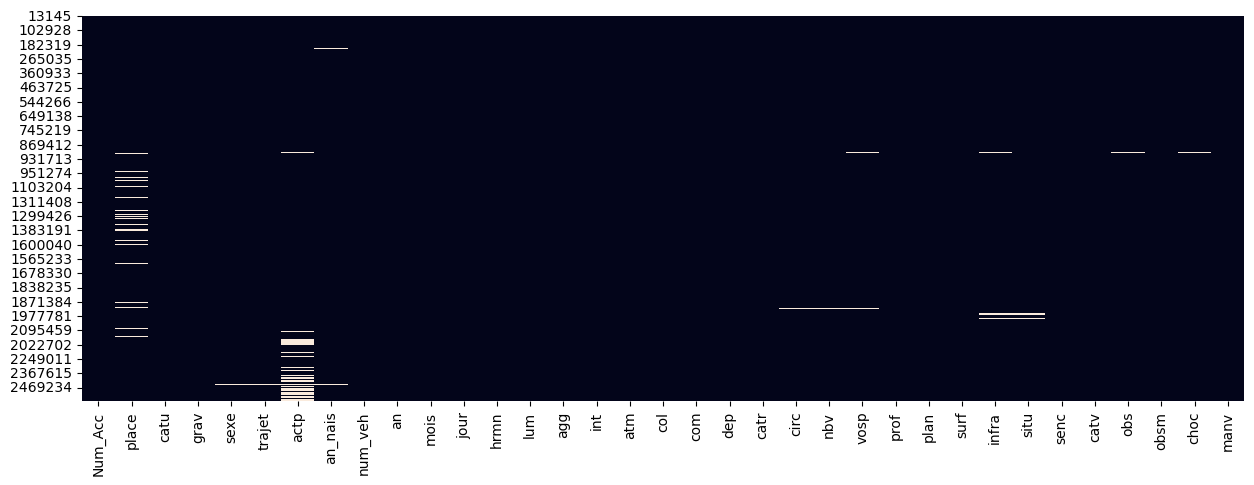

In [5]:
df_sample = df_all.sample(10000)
df_sample = df_sample.sort_values(by=['an', 'mois', 'jour'], ascending=True)

plt.figure(figsize=(15,5))
ax = sns.heatmap(df_sample.isna(), cbar=False);

### Remplacement des *Null* restants par le mode

In [6]:
df_all = pt.replace_null_mode(df_all, True)

place	-> ok (nan replaced with 1) 	- 19 columns remaining...
sexe	-> ok (nan replaced with 1.0) 	- 18 columns remaining...
trajet	-> ok (nan replaced with 5) 	- 17 columns remaining...
actp	-> ok (nan replaced with 0) 	- 16 columns remaining...
an_nais	-> ok (nan replaced with 1985) 	- 15 columns remaining...
atm	-> ok (nan replaced with 1) 	- 14 columns remaining...
col	-> ok (nan replaced with 3) 	- 13 columns remaining...
circ	-> ok (nan replaced with 2) 	- 12 columns remaining...
nbv	-> ok (nan replaced with 2) 	- 11 columns remaining...
vosp	-> ok (nan replaced with 0) 	- 10 columns remaining...
prof	-> ok (nan replaced with 1) 	- 9 columns remaining...
plan	-> ok (nan replaced with 1) 	- 8 columns remaining...
surf	-> ok (nan replaced with 1) 	- 7 columns remaining...
infra	-> ok (nan replaced with 0) 	- 6 columns remaining...
situ	-> ok (nan replaced with 1) 	- 5 columns remaining...
senc	-> ok (nan replaced with 0) 	- 4 columns remaining...
obs	-> ok (nan replaced with 0) 	- 3 

In [7]:
# Lignes contenant au moins une valeur manquante
# df_all[df_all.isna().any(axis = 1)]

### Nettoyage de la colonne *dep* (code département)

In [16]:
df_all = pt.clean_col_dep(df_all, False)

### Création et catégorisation de la variable *age*  - suppression de *an_nais*

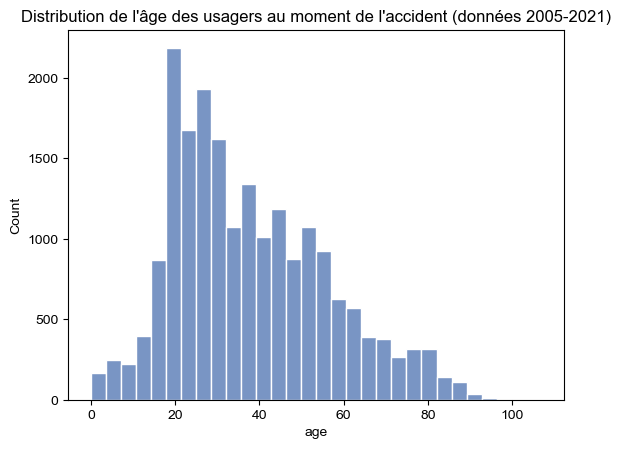

In [8]:
df_all = pt.create_col_age(df_all)

df_all = pt.rmv_outliers('an_nais', df_all)
df_all = pt.rmv_outliers('age', df_all)

df_all = df_all.drop(columns=['an_nais'], axis=1)

plt.title(f"Distribution de l'âge des usagers au moment de l'accident (données {start_year}-{end_year})")
sns.set_theme(style="ticks")
sns.histplot(data=df_all, x="age", bins=30);

###  Création de *date* - suppression de *an*, *mois*, *jour*

In [9]:
df_all = pt.create_col_date(df_all)

### Création de *joursem* (jour de la semaine)

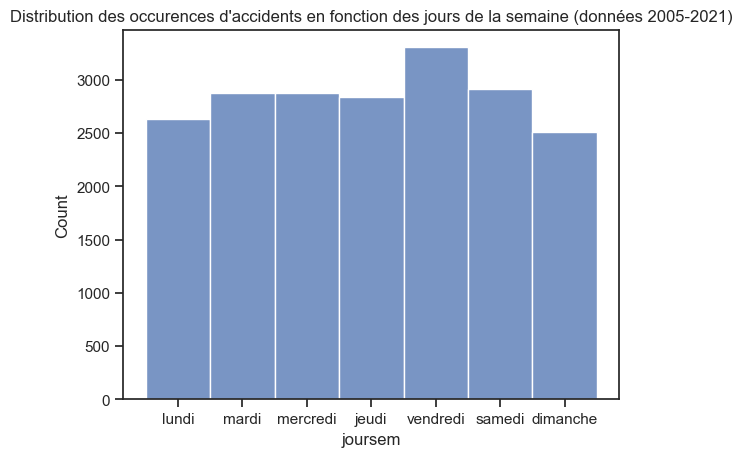

In [10]:
df_all = pt.create_col_joursem(df_all)

plt.title(f"Distribution des occurences d'accidents en fonction des jours de la semaine (données {start_year}-{end_year})")
# sns.histplot(data=df_all, x="age", hue="grav", multiple="stack", bins=30)

df_tmp = df_all
df_tmp['joursem'] = pd.Categorical(df_all['joursem'], ['lundi','mardi','mercredi','jeudi', 'vendredi', 'samedi', 'dimanche'])

sns.set_theme(style="ticks")
sns.histplot(data=df_tmp, x="joursem");

### hrmn


In [12]:
def format_hour(s):
    if len(s) == 4:
        hr = s[0:2] if len(s[0:2]) == 2 else f"0{s[0:2]}"
        mn = s[3:4] if len(s[3:4]) == 2 else f"0{s[3:4]}"
        return datetime.strptime(f"{hr}:{mn}", "%H:%M").time() 

# Suppression des lignes avec heure = None
df_all['heure'] = [format_hour(str(h)) for h in df_all.hrmn]
df_all = df_all.drop(columns=['hrmn'], axis=1)

# df_all[df_all['heure'] == None]

# df_all = df_all.drop(df_all[df_all['heure'] == None].index)

# df_all['heure'].unique()
# stats_heure = df_all['heure'].value_counts()
# type(stats_heure)
# ax = sns.histplot(stats_heure, bins=300)
# ax.set_xlim(0,500)

# sns.histplot(df_all.heure);
# plt.hist(df_all.heure)

### Variables avec nombreuses modalités

In [13]:
df_all = df_all.drop(columns=['com'], axis=1)

for col in df_all.columns:
    if not (col in ['Num_Acc', 'an_nais', 'num_veh', 'date', 'age', 'heure']):
        mods = df_all[col].unique()
        if len(mods) >= 8:
            print(f"{col} : {mods}")
#             fig = plt.figure(figsize=(4,4))
#             plt.title(col)
#             plt.hist(df_all.sample(1000)[col])




place : ['1' '2' '4' '9' '0' '3' '10' '5' '8' '7' '6']
actp : ['0' '5' '1' '3' '4' '6' '2' '9' 'B' 'A']
int : [1 3 9 7 5 2 4 8 6 0]
atm : ['1' '2' '4' '8' '3' '5' '7' '9' '6']
dep : ['110' '590' '720' '670' '750' '260' '13' '75' '44' '300' '740' '420' '77'
 '170' '76' '220' '380' '870' '370' '93' '860' '340' '94' '510' '130' '95'
 '940' '320' '770' '880' '330' '010' '350' '920' '180' '202' '84' '250'
 '520' '600' '780' '974' '760' '310' '930' '440' '61' '950' '560' '690'
 '640' '15' '910' '62' '290' '68' '030' '972' '51' '74' '971' '78' '800'
 '140' '830' '570' '810' '470' '450' '060' '120' '973' '190' '540' '790'
 '50' '86' '050' '270' '69' '500' '850' '60' '160' '280' '490' '890' '988'
 '840' '150' '630' '680' '020' '550' '67' '650' '710' '390' '430' '100'
 '201' '820' '06' '83' '090' '28' '26' '080' '30' '01' '240' '410' '210'
 '27' '360' '400' '22' '620' '580' '900' '2A' '610' '660' '34' '18' '12'
 '460' '56' '92' '91' '070' '38' '71' '2B' '230' '976' '49' '80' '02' '52'
 '14' '29'

### Volume des données

In [14]:
# nb de lignes et colonnes de chaque DataFrame

dic = {'caract' : dic_caract, 'lieux' : dic_lieux, 'usagers': dic_usagers, 'vehic' : dic_vehic}

for key in dic.keys() : 
    print(f"\n{key} : \n")
    nb_lin = []
    nb_col = []
   
    for year in range(start_year, end_year+1):
        dic_data = dic[key]
        df = dic_data[year]
        nb_lin.append(df.shape[0])
        nb_col.append(df.shape[1])
        print(f'{key} {year} : {df.shape[1]} colonnes x {df.shape[0]} lignes')

    print(f"\nnombre de lignes min : {min(nb_lin)}")    
    print(f"\nnombre de lignes max : {max(nb_lin)}")    

NameError: name 'dic_caract' is not defined

### Analyse intercorrelations between variables

In [ ]:
target = df_all['grav']
data = df_all.drop(columns=['grav'], axis=1)
# set 'grav' as last column of data
data['grav'] = target

# data = data.fillna(data.median())
# data_clean = data.dropna(how='any')

data_sample = data.sample(10000)
corr = data_sample.corr()

sns.heatmap(corr, annot=False, cmap='coolwarm');
# sns.clustermap(corr, annot=False, cmap='coolwarm');

### Evolution de gravité 'Blessé hospitalisé' en 2019?

In [ ]:
df_usagers_start = df_all[df_all.an == start_year]
df_usagers_end = df_all[df_all.an == end_year]

# sns.histplot(df_usagers_2018.grav)
# ax = plt.hist([df_usagers_2018.grav, df_usagers_2019.grav], color=['r', 'b'], alpha=0.5)

print(f"\nDistribution de la variable gravité en {start_year}")
print(df_usagers_start.grav.value_counts(normalize=True))

print(f"\nDistribution de la variable gravité en {end_year}")
print(df_usagers_end.grav.value_counts(normalize=True))